# Proyecto Mecánica Estadística Computacional 
# Esteban Porras Marín C26021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter

Se quiere simular el modelo de lattice-gas mediante técnicas de Monte-Carlo, para esto definimos los siguientes parámetros a utilizar:

In [2]:
# Parámetros
L = 10 # Tamaño de la grilla
dT = 200 # Espaciamiento entre temperaturas 
T = np.linspace(0.1, 15.0, dT) # Rango de temperaturas
epsilon = 1.0 # Energía de interacción
kb = 1.0 # Constante de boltzmann J/K
mu = 1.0 # Potencial químico

E_0 = np.random.choice([0,1], size=(L,L)) # Configuración inicial aleatoria

Para esto usamos el Hamiltoniano normalmente usado para este modelo:

$$
\boxed{
 H = -\epsilon \sum_{\langle i,j \rangle} n_in_j - \mu \sum_i n_i 
}
$$

Donde la primera sumatoria es sobre los vecinos (arriba, abajo, derecha, izquierda) y la segunda solo en la propia posición. 

Escribimos el Hamiltoniano en python de la siguiente manera:

In [3]:
def Hamiltoniano(Ei, mu, epsilon): # Cálculo del Hamiltoniano
    Lx, Ly = Ei.shape 
    H = 0.0 
    for i in range(Lx):
        for j in range(Ly):
            H += -epsilon * Ei[i,j] * Ei[(i+1) % Lx, j] # Interacción con el vecino inferior
            H += -epsilon * Ei[i,j] * Ei[i ,(j+1) % Ly] # Interacción con el vecino derecho
            # Solo calculamos con respecto a los vecinos inferior y derecho para evitar doble conteo
            H += -mu * Ei[i,j]
            # Hago % Lx debido a que quiero condiciones de frontera periódicas
    return H 

Para el algoritmo de metropolis necesitaremos un $\Delta E$, el cual no calcularemos realizando $\Delta E = H_2 - H_1$ pues por cada posición deberiamos calcular dos Hamiltonianos (Energías). En cambio hagamos el siguiente análisis. Sea un sitio fijo $r$ con ocupación $n_r$, y definamos la suma de las ocupaciones de sus vecinos como:

\begin{equation}
S = \sum_{\text{vecinos}} n_v = n_{i+1,j} + n_{i-1,j} + n_{i,j+1} + n_{i,j-1}
\end{equation}

La energía local asociada al sitio $r$ antes de modificarlo es:

\begin{equation}
E_\text{viejo}^{(r)} = -\epsilon\, n_r S - \mu\, n_r.
\end{equation}

Si el sitio cambia de estado ($n_r' = 1 - n_r$), la nueva energía local es:

\begin{equation}
E_\text{nuevo}^{(r)} = -\epsilon\, (1 - n_r) S - \mu\, (1 - n_r).
\end{equation}

El cambio de energía al realizar este ``cambio'' sería:

\begin{align}
\Delta E &= E_\text{nuevo}^{(r)} - E_\text{viejo}^{(r)} = \big[-\epsilon(1-n_r)S -\mu(1-n_r)\big] - \big[-\epsilon n_r S -\mu n_r\big] \\
&= -\epsilon[(1-n_r)-n_r]S -\mu[(1-n_r)-n_r] \\
&= -\epsilon(1-2n_r)S -\mu(1-2n_r) \\
&= \epsilon(2n_r-1)S + \mu(2n_r-1).
\end{align}

Por tanto, el cambio de energía es:

\begin{equation}
\boxed{
\Delta E = \epsilon (2n_{r} - 1) \sum_{\text{vecinos}(r)} n_v + \mu (2n_{r} - 1)
}
\end{equation}

In [4]:
def delta_E(Ei, i, j, epsilon, mu):
    n_ij = Ei[i, j]
    Lx, Ly = Ei.shape

    # Vecinos 
    n_up    = Ei[(i-1) % Lx, j] # vecino abajo
    n_down  = Ei[(i+1) % Lx, j] # vecino arriba
    n_left  = Ei[i, (j-1) % Ly] # vecino izquierda
    n_right = Ei[i, (j+1) % Ly] # vecino derecha

    vecinos = n_up + n_down + n_left + n_right

    # Cambio de energía si se cambia el sitio
    deltaE = epsilon * (2*n_ij - 1) * vecinos + mu * (2*n_ij - 1)
    return deltaE

Para verificar que la ecuación para $\Delta E$ es igual que relizar $H_2 - H_1$ realizamos una función que comprueba esto:

In [5]:
def verificar_deltaE(Ei, mu, epsilon, n_pruebas=5):
    for _ in range(n_pruebas):
        # Elegir un sitio aleatorio
        Lx, Ly = Ei.shape
        i = np.random.randint(0, Lx)
        j = np.random.randint(0, Ly)

        # Calcular energía total antes
        E_vieja = Hamiltoniano(Ei, mu, epsilon)

        # Calcular deltaE local
        dE_local = delta_E(Ei, i, j, epsilon, mu)

        # Flipa el sitio (0 ↔ 1)
        Ei[i, j] = 1 - Ei[i, j]

        # Calcular energía total nueva
        E_nueva = Hamiltoniano(Ei, mu, epsilon)

        # ΔE global
        dE_global = E_nueva - E_vieja

        # Volver a dejar el sitio como estaba
        Ei[i, j] = 1 - Ei[i, j]

        print(f"Sitio ({i},{j}) → ΔE_local = {dE_local:.6f}, ΔE_global = {dE_global:.6f}")

verificar_deltaE(np.copy(E_0), mu, epsilon)

Sitio (3,7) → ΔE_local = 3.000000, ΔE_global = 3.000000
Sitio (0,3) → ΔE_local = -2.000000, ΔE_global = -2.000000
Sitio (1,6) → ΔE_local = -2.000000, ΔE_global = -2.000000
Sitio (5,5) → ΔE_local = 2.000000, ΔE_global = 2.000000
Sitio (6,6) → ΔE_local = 2.000000, ΔE_global = 2.000000


Ahora definimos la función más importante, la función que realiza el algoritmo de metrópolis.
Para esto la función elige una posición al azar mediante "np.random.randint(0,L)" y calculamos cuanto es el cambio de energía si cambiaramos esa posición. 

Aceptamos o rechazamos que ocurra este cambio de acuerdo a una regla sencilla:

Si $\Delta E \leq 0$ siempre se acepta el cambio. Pero si $\Delta E \geq 0$ entonces recurrimos a una elección aleatoria 

In [6]:
def metropolis(Ei, T, mu, epsilon):
    Lx, Ly = Ei.shape
    for intento in range(Lx * Ly):
        # Elegir un sitio aleatorio
        i = np.random.randint(0, Lx)
        j = np.random.randint(0, Ly)

        # Calcular el cambio de energía
        dE = delta_E(Ei, i, j, epsilon, mu)

        # Criterio de Metropolis
        if dE <= 0: # Aceptar siempre si la energía disminuye
            Ei[i,j] = 1 - Ei[i,j] 
        else:
            # Aceptar de acuerdo a la probabilidad de Boltzmann
            prob = np.exp(-dE / (kb * T)) # Probabilidad de aceptación
            if np.random.rand() < prob: # Si el numero aleatorio es menor que la probabilidad se acepta el cambio
                Ei[i,j] = 1 - Ei[i,j]

    return Ei

Definimos una función que calcula todas las cantidades de interés.

In [7]:
def calcular_Cantidades(T, Ei, mu, epsilon):
    L,L = Ei.shape

    # Se debe llegar a un estado estable antes de medir
    for _ in range(200):
        Ei = metropolis(Ei, T, mu, epsilon)

    # Acumuladores para promedios
    E_total = 0 # E
    E2_total = 0 # E^2
    rho_total = 0 # Densidad
    N_medidas = 700 # Número de medidas
        
    for _ in range(N_medidas):
        Ei = metropolis(Ei, T, mu, epsilon) # Ejecución de Metropolis
        E = Hamiltoniano(Ei, mu, epsilon) / (L*L) # Energía en el estado actual por sitio

        E_total  += E 
        E2_total += E**2 
        rho_total += np.mean(Ei) 
        
    E_mean = E_total / N_medidas # Energía promedio
    E2_mean = E2_total / N_medidas # Energía al cuadrado promedio
         
    rho = rho_total / N_medidas # Densidad promdio
        
    C_V = (E2_mean - E_mean**2) / (kb * T**2) # Capacidad calorífica

    return Ei, E_mean, rho, C_V

In [8]:
E_vals = np.zeros(T.size) # Valores de la energía promedio
rho_vals = np.zeros(T.size) # Valores de la densidad promedio
C_V_vals = np.zeros(T.size) # Valores de la capacidad calorífica 

Ei = np.copy(E_0) # Hacemos una copia para no modificar el estado inicial

# Realizamos todos los cálculos
for t in range(T.size):
    Ei, E_vals[t], rho_vals[t], C_V_vals[t]  = calcular_Cantidades(T[t], Ei, mu, epsilon)

Una vez realizamos todo lo anterior podemos proceder a graficar los resultados obtenidos. Empezamos graficando la energía promedio $E(T)$ y la densidad promedio $\rho (T)$ en función de la temperatura:

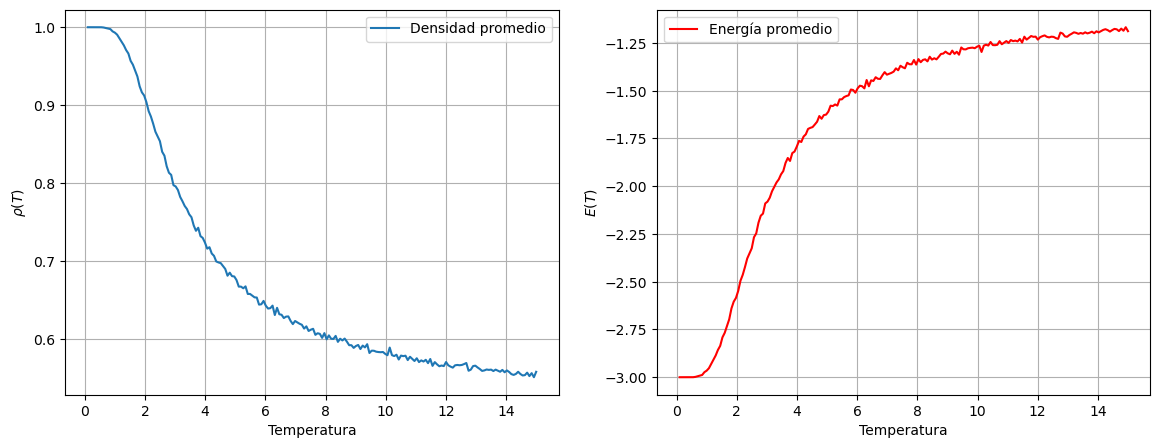

In [9]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(T, rho_vals, label="Densidad promedio")
plt.xlabel("Temperatura")
plt.ylabel(r"$\rho (T)$")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(T, E_vals, label="Energía promedio", color='red')
plt.ylabel(r"$E(T)$")
plt.xlabel("Temperatura")
plt.legend()
plt.grid()

#plt.savefig("graficos1.pdf")
plt.show()

Con la energía podemos obtener la capacidad calorífica con:
$$
\boxed{
C_V(T) \;\approx\; \frac{ \langle E^2 \rangle - \langle E \rangle ^2}{k_B T^2}
}
$$
Entonces ahora hallaremos la capacidad calorífica $C_V$ y veremos para cual $T$ ocurre la transición de fase

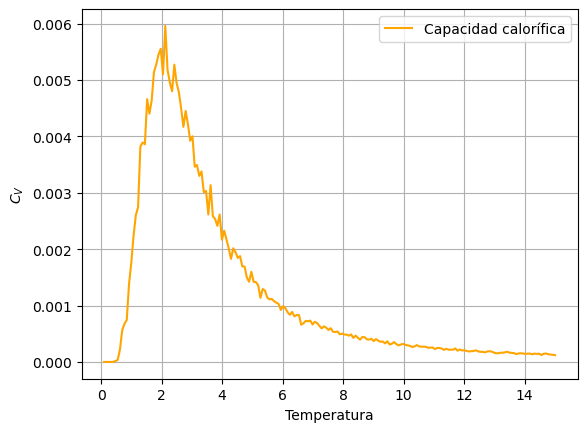

In [10]:
plt.plot(T, C_V_vals, label="Capacidad calorífica", color="orange")
plt.xlabel("Temperatura")
plt.ylabel("$C_V$")
plt.legend()
plt.grid()

#plt.savefig("graficos2.pdf")
plt.show()

De la gráfica podemos ver que ocurre un cambio drástico de la capacidad calorífica en $T \approx 2$, esto quiere decir que en esa temperatura ocurre la transición de fase. Esta sería la transición de un líquido (mayor densidad) a un gas (menor densidad).

Ahora realizaremos una animación que muestra como evoluciona el sistema conforme la temperatura aumenta.

In [11]:
# Función de animación 
def animar(frame):
    global latt_ani

    # Obtener temperatura correspondiente al frame
    temp = T_anim[frame % len(T_anim)]   

    # Estado final y mediciones
    latt_ani, E_mean, rho, C_V = calcular_Cantidades(temp, latt_ani, mu, epsilon)

    # Actualizar imagen
    im.set_data(latt_ani)
    ax.set_title(f"T = {temp:.2f}, E = {E_mean:.2f}, $\\rho$ = {rho:.2f}, $C_V$ = {C_V:.4f} ")

    return [im]

# Figura 
latt_ani = np.copy(E_0)
fig, ax = plt.subplots()
im = ax.imshow(latt_ani, cmap="magma", interpolation="nearest")
fig.colorbar(im, ax=ax)
ax.axis("off")

# Crear la animación 
T_anim = np.linspace(0.1, 7, dT)
num_frames = len(T_anim) 

anim = FuncAnimation(fig, animar, frames=num_frames, interval=80, blit=True)
plt.close(fig)

# Guardar como MP4 
writer = FFMpegWriter(fps=15)
anim.save("lattice_anim.mp4", writer=writer)

print("¡Video guardado como lattice_anim.mp4!")

¡Video guardado como lattice_anim.mp4!
